In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import sys
import pickle
import os
import time as tm
from functools import partial
import scipy.stats as st
from scipy.stats import wasserstein_distance
import scipy.stats
import copy
from sklearn.model_selection import KFold
import pandas as pd
import multiprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc
import warnings

warnings.filterwarnings('ignore')

from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
from sklearn.metrics import matthews_corrcoef
from scipy import stats
import seaborn as sns
import torch
from scipy.spatial.distance import cdist
import h5py
from scipy.stats import spearmanr

import time
import sys
import tangram as tg
from os.path import join
from IPython.display import display
from process.data import *

## Fig2

In [ ]:

plt.style.use('default')

real_spatial = sc.read_h5ad('datasets/sp/dataset2_spatial_33.h5ad')
real_seq_share = sc.read_h5ad('datasets/sc/dataset2_seq_33.h5ad')

sc.pp.normalize_total(real_seq_share, target_sum=1e4)
sc.pp.log1p(real_seq_share)
real_seq_share = scale(real_seq_share)

sc.pp.normalize_total(real_spatial, target_sum=1e4)
sc.pp.log1p(real_spatial)
real_spatial = scale(real_spatial)

impute_spatial_share = pd.read_csv('Result/dataset2_base/diffusion_impute.csv', header=0, index_col=0)

def cluster(file, impu_share_data):

    real_spatial_share = real_spatial.copy()

    impu_share = real_spatial.copy()
    impu_share.X = impu_share_data
    
    rna_share = real_seq_share.copy()
    
    # share batch
    real_spatial_share.obs[file] = 'ST_real'
    real_spatial_share.obs[file] = real_spatial_share.obs[file].astype('category')
    impu_share.obs[file] = 'ST_impu'
    impu_share.obs[file] = impu_share.obs[file].astype('category')
    rna_share.obs[file] = 'RNA_real'
    rna_share.obs[file] = rna_share.obs[file].astype('category') 
        
    merge_share = ad.concat([real_spatial_share, impu_share, rna_share])
    plot_hvg_umap(merge_share, color=[file], path='Result/batch/dataset2/' , save_filename=file )
    
    return
cluster('stDiff', impu_share_data=impute_spatial_share)

## Fig3

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


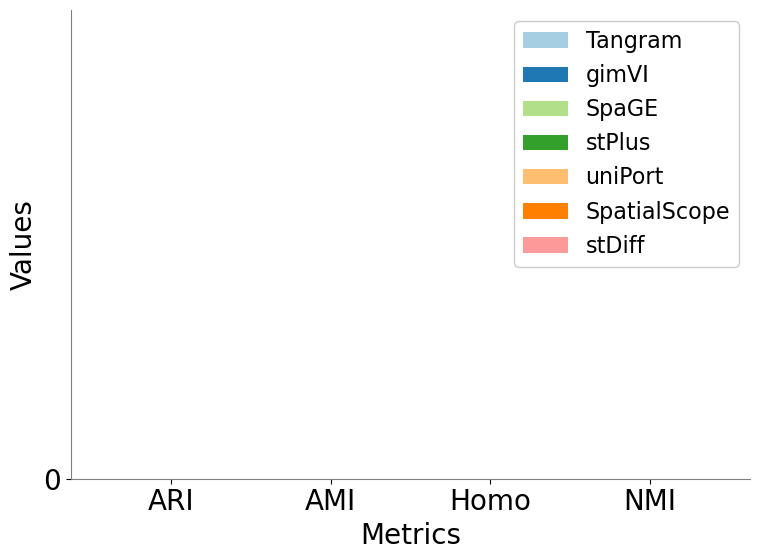

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
plt.style.use('default')
# 设置全局字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

# 示例数据，替换为你自己的数据
indicators = ['ARI', 'AMI', 'Homo', 'NMI']
methods = ['Tangram', 'gimVI', 'SpaGE', 'stPlus', 'uniPort', 'SpatialScope', 'stDiff']

# 替换为你自己的数据集的聚类均值，
data_str="""0	0	0	0	0	0	0
0	0	0	0	0	0	0
0	0	0	0	0	0	0
0	0	0	0	0	0	0"""

# 将字符串转换为 NumPy 数组
data = np.array([list(map(float, line.split())) for line in data_str.split('\n')])


# 设置图的大小
fig = plt.figure(figsize=(8, 6))

# 设置柱状图的宽度和小间隔、大间隔
bar_width = 0.115
small_bar_gap = 0.01  # 小间隔的宽度
large_bar_gap = 0.15  # 大间隔的宽度

# 设置颜色
colors =   ["#a6cee3", '#1f78b4', "#b2df8a", "#33a02c", '#fdbf6f', "#ff7f00", "#fb9a99"]

# 获取数据的最大值
max_value = np.max(data)
plt.yticks(np.arange(0, max_value + 0.1, 0.2), fontsize=20)
# 设置y轴的高度为最大值
plt.ylim(0, max_value + 0.1)  # 可以根据需要进行微调

# 添加水平灰线
# for y_tick in np.arange(0.2, max_value + 0.1, 0.2):
    # plt.axhline(y_tick, color='gray', linestyle='-', linewidth=0.15, zorder=0, alpha=0.3)


# # 绘制柱状图
for i, method in enumerate(methods):
    bars = plt.bar(np.arange(len(indicators)) + (bar_width + small_bar_gap) * i, data[:, i], bar_width, label=method, color=colors[i])

# 设置横坐标标签和标题
plt.xlabel('Metrics')
plt.ylabel('Values')

# 设置横坐标刻度
# center_positions = np.arange(len(indicators)) + ((bar_width + small_bar_gap) * 2 + large_bar_gap - 0.15 ) / 2  # 对应第三根柱子的位置
center_positions = np.arange(len(indicators)) + (bar_width + small_bar_gap) * (len(methods) - 1) / 2
# center_positions = np.arange(len(indicators)) + ((bar_width + small_bar_gap) * len(methods) - small_bar_gap) / 2
plt.xticks(center_positions, indicators, ha='center', fontsize=20)  # 修改此行



# 添加横向展示的图例到右上方，并使用HandlerSquare设置色块为正方形
legend = plt.legend(loc='upper right', fontsize=16, framealpha=1)  # 调整图例位置


# 设置坐标轴颜色为灰色
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')

# # 去掉上边和右边的边框线
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 在绘制完图之后添加
plt.tight_layout()


plt.savefig('Result/stDiff/legend.pdf', bbox_inches='tight')
# 显示图形
plt.show()



## Fig4

In [ ]:
plt.style.use('default')
path = 'Result/stDiff/'
Tools= ['Tangram', 'gimVI', 'SpaGE', 'stPlus', 'uniport', 'spscope', 'diffusion']
def make_plot_one_dataset(path, Data,metric,part):
    Tools_data=[x for x in range(len(Tools))]
    # dataset = pd.read_csv(path  + Data +'/'+ part + '_score.txt', header = 0, index_col = 0)
    a = pd.DataFrame()
    for i in range(len(Tools)):
        File = path + '/' + Data + '/' + Tools[i] + part +'_Metrics.txt'
        if os.path.isfile(File): 
            print("*********************")
            Tools_data[i] = pd.read_table(path + '/' + dataset + '/' + Tools[i] + part+'_Metrics.txt',sep='\t',index_col=0, header=0)
        a = pd.concat([a, Tools_data[i][metric]], axis=1) 
    a.columns = ['Tan', 'gim', 'Spa', 'stP','uni', 'SpS', 'stD']    
    a_melted = a.melt(var_name='Method', value_name='Value')
    
    if metric in ['SPCC', 'SSIM']:
        a_melted['Value'] = 1 - a_melted['Value']
    
    if metric == 'JS':
        a_melted = a_melted[a_melted['Value'] <= 1]
    
    # 设置颜色
    colors =  ["#a6cee3", '#1f78b4', "#b2df8a", "#33a02c", '#fdbf6f', "#ff7f00", "#fb9a99"]
    
    # 设置全局字体
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = 'Times New Roman'
    plt.rcParams['font.size'] = 23
    
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # for y_tick in np.arange(0.2, 1 , 0.2):
        # plt.axhline(y_tick, color='gray', linestyle='-', linewidth=0.2, zorder=0)
    # Create a violin plot using Seaborn
    sns.violinplot(x='Method', y='Value', data=a_melted, palette=colors, inner='quartile', showfliers=False)

    # 设置坐标轴颜色为灰色
    plt.gca().spines['left'].set_color('gray')
    plt.gca().spines['bottom'].set_color('gray')
    # 去掉上边和右边的边框线
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)   
    # Set plot labels and title
    
    # 设置横坐标斜一下
    plt.xticks(rotation=0, ha='right')
    # if metric in ['SPCC', 'SSIM']:
    #     plt.title('1 - ' + metric)
    # else: plt.title(metric)
    # plt.title(metric)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(ha='center', fontsize=30)  # 修改此行
    plt.yticks(fontsize=30)  # 修改此行for i in metrics:
    plt.savefig('violin/' + Data +'_'+metric + '.pdf', bbox_inches='tight')
    plt.show()
    
parts = ['_gene']
dataset='dataset10_std'
metrics = ['SPCC','SSIM', 'RMSE', 'JS']
for i in metrics:
    make_plot_one_dataset(path, dataset, i, parts[0])



## Fig5

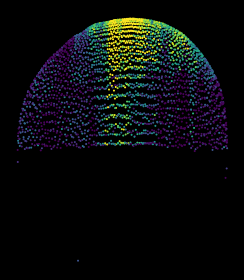

In [11]:
#  marker基因的空间表达图
plt.style.use('dark_background')
# plt.style.use('default')

dataset_name = 'dataset8_std'
dataset = 'dataset8_spatial_84.h5ad'
dot_size = 1

impu_array = pd.read_csv('Result/stDiff/' + dataset_name +  '/diffusion_impute.csv', header=0, index_col=0)

adata_spatial3 = sc.read_h5ad('datasets/sp/' + dataset)
sc.pp.normalize_total(adata_spatial3, target_sum=1e4)
sc.pp.log1p(adata_spatial3)
adata_spatial3 = scale(adata_spatial3)
origin_array = pd.DataFrame(adata_spatial3.X, columns=adata_spatial3.var_names)

adata_imputation = adata_spatial3.copy()
adata_imputation.X = impu_array

genes = ['sna',  'trn', 'tkv', 'Antp'] 

i = 3
#data9 47 85 87  109  147     #data2 21  #data7  18 19 24 169
# fig,(ax1, ax2) = plt.subplots(2,1, figsize=(3, 6))
fig1, ax1 = plt.subplots(figsize=(3.5, 4))
ax1.axis('off')
cmap = origin_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax1.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap )
# ax1.set_title('ground truth', fontsize = 17)
plt.tight_layout()
plt.savefig('Result/stDiff/dataset8_std' + '_spatial location' + genes[i] + 'gt.pdf')
plt.close(fig1)

fig2, ax2 = plt.subplots(figsize=(3.5, 4))
ax2.axis('off')
cmap = impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax2.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
# ax2.set_title('stDiff', fontsize = 17)
plt.tight_layout()  # Add this line
plt.savefig('Result/stDiff/dataset8_std'+ '_spatial location' + genes[i] + 'stD.pdf')

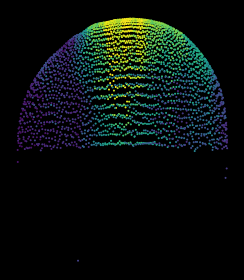

In [12]:
#  marker基因的空间表达图
plt.style.use('dark_background')
SpaGE_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/SpaGE_impute.csv', header=0, index_col=0)
stPlus_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/stPlus_impute.csv', header=0, index_col=0)
# uniPort_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/uniport_impute.csv', header=0, index_col=0)

adata_spatial3 = sc.read_h5ad('datasets/sp/' + dataset)
sc.pp.normalize_total(adata_spatial3, target_sum=1e4)
sc.pp.log1p(adata_spatial3)
origin_array = pd.DataFrame(adata_spatial3.X, columns=adata_spatial3.var_names)

adata_imputation = adata_spatial3.copy()


# fig,(ax1, ax2) = plt.subplots(1,2, figsize=(5, 3))
fig1, ax1 = plt.subplots(figsize=(3.5, 4))
ax1.axis('off')
cmap = SpaGE_impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax1.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
# ax1.set_title('SpaGE', fontsize = 17)
plt.tight_layout()
plt.savefig('Result/stDiff/dataset8_std' + '_spatial location' + genes[i] + 'Spa.pdf')
plt.close(fig1)

fig2, ax2 = plt.subplots(figsize=(3.5, 4))
ax2.axis('off')
cmap = stPlus_impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax2.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
# ax2.set_title('stPlus', fontsize = 17)
plt.tight_layout()  # Add this line
plt.savefig('Result/stDiff/dataset8_std'+  '_spatial location' + genes[i] + 'stP.pdf')

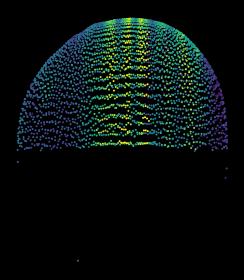

In [13]:
#  marker基因的空间表达图
plt.style.use('dark_background')
gimVI_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/gimVI_impute.csv', header=0, index_col=0)
Tangram_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/Tangram_impute.csv', header=0, index_col=0)

adata_spatial3 = sc.read_h5ad('datasets/sp/' + dataset)
sc.pp.normalize_total(adata_spatial3, target_sum=1e4)
sc.pp.log1p(adata_spatial3)
origin_array = pd.DataFrame(adata_spatial3.X, columns=adata_spatial3.var_names)

adata_imputation = adata_spatial3.copy()


# fig,(ax1, ax2) = plt.subplots(1,2, figsize=(5, 3))
fig1, ax1 = plt.subplots(figsize=(3.5, 4))
ax1.axis('off')
cmap = Tangram_impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax1.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
# ax1.set_title('Tangram', fontsize = 17)
plt.tight_layout()
plt.savefig('Result/stDiff/dataset8_std' + '_spatial location' + genes[i] + 'Tan.pdf')
plt.close(fig1)

fig2, ax2 = plt.subplots(figsize=(3.5, 4))
ax2.axis('off')
cmap = gimVI_impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax2.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
# ax2.set_title('gimVI' , fontsize = 17)
plt.tight_layout()  # Add this line
plt.savefig('Result/stDiff/dataset8_std'+   '_spatial location' + genes[i] + 'gim.pdf')

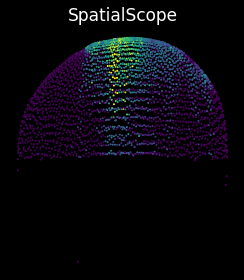

In [14]:
#  marker基因的空间表达图
plt.style.use('dark_background')
uniPort_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/uniport_impute.csv', header=0, index_col=0)
SpatialScope_impu_array = pd.read_csv('Result/stDiff/' + dataset_name + '/spscope_impute.csv', header=0, index_col=0)

adata_spatial3 = sc.read_h5ad('datasets/sp/' + dataset)
sc.pp.normalize_total(adata_spatial3, target_sum=1e4)
sc.pp.log1p(adata_spatial3)
origin_array = pd.DataFrame(adata_spatial3.X, columns=adata_spatial3.var_names)

adata_imputation = adata_spatial3.copy()


# fig,(ax1, ax2) = plt.subplots(1,2, figsize=(5, 3))
fig1, ax1 = plt.subplots(figsize=(3.5, 4))
ax1.axis('off')
cmap = uniPort_impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax1.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
ax1.set_title('uniPort', fontsize = 17)

plt.tight_layout()
plt.savefig('Result/stDiff/dataset8_std' + '_spatial location' + genes[i] + 'uni.pdf')
plt.close(fig1)

fig2, ax2 = plt.subplots(figsize=(3.5, 4))
ax2.axis('off')
cmap = SpatialScope_impu_array[genes[i]]
cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
ax2.scatter(adata_imputation.obs['x_coord'],adata_imputation.obs['y_coord'],s=dot_size,c=cmap)
ax2.set_title('SpatialScope' , fontsize = 17)
plt.tight_layout()  # Add this line
plt.savefig('Result/stDiff/dataset8_std'+   '_spatial location' + genes[i] + 'SpS.pdf')

## Fig6

In [16]:
path = 'Result/stDiff/'
 
# 计算每个数据集每个方法的聚类分数

def get_score(Result):
    Result = Result.fillna(0)
    tools_num = Result.shape[0]
    Tools_score=[]
    methods = list(Result.index)
    score_col = []
    list_up = list(range(1,Result.shape[1]+1))
    list_down  = list(range(Result.shape[1],0,-1))
    
    for method in methods:
        if method == 'SPCC' or method == 'PCC' or method == 'SSIM':
            Tools_score.append(pd.Series(list_down, index=Result.loc[method,:].sort_values(ascending=False).index))
            
        if method == 'JS' or method == 'RMSE':
            Tools_score.append(pd.Series(list_up, index=Result.loc[method,:].sort_values(ascending=False).index))
        
        if method == 'ARI' or method == 'AMI' or method == 'Homo' or method == 'NMI':
            Tools_score.append(pd.Series(list_down, index=Result.loc[method,:].sort_values(ascending=False).index))
        
        score_col.append(method)
        
    score=pd.concat([m for m in Tools_score],axis=1)
    score.columns = score_col
    score = score/Result.shape[1]
    return score

def make_score(path, dataset_all, Tools, path_output, part):
    Tools_data=[x for x in range(len(Tools))]
    
    a = pd.DataFrame()
    
    for dataset in dataset_all:
        for i in range(len(Tools)):
            File = path + '/' + dataset + '/' + Tools[i] + part +'_Metrics.txt'
            if os.path.isfile(File): 
                Tools_data[i] = pd.read_table(path + '/' + dataset + '/' + Tools[i] + part+'_Metrics.txt',sep='\t',index_col=0, header=0)
                # Tools_data[i] = Tools_data[i].mean()
                Tools_data[i] = Tools_data[i].median()
                Tools_data[i]['Tool'] = Tools[i]

        Result=pd.concat([m for m in Tools_data], axis=1)
        Result.columns = Result.loc[["Tool"],:].values.flatten()
        Result.drop('Tool', axis = 0, inplace = True)    
        print(Result)
        print(dataset)
        
        a = pd.concat([a, Result], axis = 0)
        
        score = get_score(Result)
        score.to_csv(path_output + dataset +part+ "_score.txt", header=1, index=1)
    a.to_csv(path_output  +part+ "_metrics.csv", header=1, index=1)

path_output = path + 'Accuracy_Rank/'
if not os.path.exists(path_output):
    os.mkdir(path_output)
Tools = ['Tangram', 'gimVI', 'SpaGE', 'stPlus', 'uniport', 'spscope', 'diffusion']
DirFiles = os.listdir(path)
dataset_all = [x for x in DirFiles if (x[:7] == 'dataset' and x[-3:] == 'std')]

print (len(dataset_all))
parts = ['_gene', '_cluster']
for i in [0,1]:
    make_score(path, dataset_all, Tools, path_output, parts[i])



15
       Tangram     gimVI     SpaGE    stPlus   uniport     spscope diffusion
SPCC  0.251726   0.21425  0.217883  0.217787   0.21532   0.0774011  0.251387
SSIM  0.193064  0.150719  0.168239  0.165096  0.134607  0.00632984  0.150055
RMSE   1.21887   1.25432   1.22905   1.22844   1.24943      1.3487   1.24791
JS    0.303484  0.304002  0.320898  0.309088   0.30283    0.546556  0.307502
dataset13_std
       Tangram      gimVI    SpaGE    stPlus    uniport    spscope diffusion
SPCC  0.230086   0.194805  0.12712  0.131892   0.155513  0.0709773  0.195728
SSIM  0.120321  0.0944284  0.11919  0.089361  0.0989798  0.0509566  0.118473
RMSE   1.24661    1.28172  1.28809   1.28303    1.30705    1.32965   1.27487
JS    0.408343   0.410944  0.43539  0.429992   0.410817    0.54146  0.411336
dataset6_std
       Tangram     gimVI     SpaGE    stPlus   uniport    spscope diffusion
SPCC  0.172432  0.235314  0.327251   0.35178  0.199058   0.251378  0.285342
SSIM  0.111596  0.158851  0.273398  0.306642  0.

['dataset13_std', 'dataset6_std', 'dataset3_std', 'dataset8_std', 'dataset11_std', 'dataset15_std', 'dataset2_std', 'dataset12_std', 'dataset5_std', 'dataset10_std', 'dataset4_std', 'dataset14_std', 'dataset16_std', 'dataset7_std', 'dataset9_std']
15
              merge
Tangram    0.857143
diffusion  3.428571
SpaGE      3.857143
stPlus     3.000000
uniport    1.857143
...             ...
SpaGE      1.285714
gimVI      2.857143
diffusion  3.857143
Tangram    0.571429
uniport    1.714286

[105 rows x 1 columns]


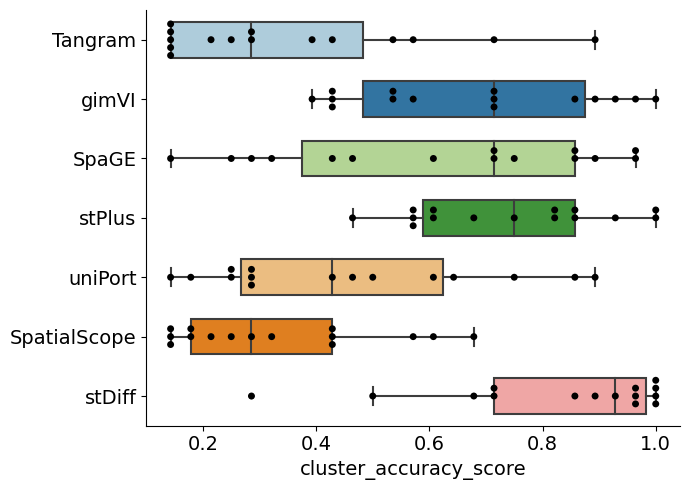

In [19]:
# 画图所有数据集
plt.style.use('default')
import os
def make_all_score(path, dataset_all, part):
    score_all = pd.DataFrame()
    for dataset in dataset_all:
        a = pd.read_csv(path + '/Accuracy_Rank/'+dataset+ part+ "_score.txt",header=0,index_col=0)
        a['DataSet'] = dataset

        score_all=pd.concat([score_all,a],axis=0)
    return score_all

def make_all_score_all_metrics(path, dataset_all, parts):
    score_all = pd.DataFrame()
    for dataset in dataset_all:
        a = pd.DataFrame()
        for part in parts:
            t = pd.read_csv(path + '/Accuracy_Rank/' + dataset + part + '_score.txt', header=0, index_col=0)
            a = pd.concat([a, t], axis=1)
        a['Dataset'] = dataset
        
        score_all = pd.concat([score_all, a], axis = 0)
    return score_all

def plot_all(df, name, order, palette, path):
    # df = df[['SPCC', 'SSIM', 'RMSE', 'JS','ARI', 'AMI', 'Homo', 'NMI']] # 8 
    df = df[[ 'ARI', 'AMI', 'Homo', 'NMI']] # 4 
    # df = df[['SPCC', 'SSIM', 'RMSE', 'JS']] # 4 /
     
    df_all = pd.DataFrame(df.sum(axis=1).values,index = df.index.values,columns=['merge'])
    
    # print('all')
    print(df_all)
    df_all = df_all/4
    # df_all = df_all / 8
    # df_all.to_csv('all_score.txt')
    
    # df_all = df_all / 12
    
    plt.figure(figsize=(7, 5))
    axes =sns.boxplot(x= 'merge',y= df_all.index.values, data=df_all ,palette=palette,order=order,flierprops = dict(marker='o', markersize=3), width=0.6)
    axes = sns.swarmplot(x = 'merge', y = df_all.index.values, data = df_all, order = order, color = "black", size = 5)
    axes.set_xlabel(name, fontsize=14)
    axes.set_ylabel('', fontsize=10)
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    # 修改 x 轴标签
    axes.set_yticklabels(['Tangram', 'gimVI', 'SpaGE', 'stPlus', 'uniPort', 'SpatialScope', 'stDiff'])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.subplots_adjust(wspace=0)  # 调整水平间距
    plt.tight_layout()
    plt.savefig(path + "/Accuracy_Rank/" + name + '_boxplot.pdf')
    plt.show()

# path = 'Result/FigureData/Figure2/'
# os.popen('mkdir ' + path + 'Accuracy_Rank')
# path_output = path + '/Accuracy_Rank/'
order = ['Tangram', 'gimVI', 'SpaGE', 'stPlus', 'uniport', 'spscope', 'diffusion']
Tools= ['Tangram', 'gimVI', 'SpaGE', 'stPlus', 'uniport', 'spscope', 'diffusion']
palette = ["#a6cee3", '#1f78b4', "#b2df8a", "#33a02c", '#fdbf6f', "#ff7f00", "#fb9a99"]

DirFiles = os.listdir(path)
# DataSets = [x for x in DirFiles if x[:4] == 'data' and x[-15:] == 'std']
DataSets = dataset_all
print(dataset_all)
# image_based_dataset = ['Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8', 'Data9', 
            # 'Data10', 'Data11', 'Data12', 'Data13', 'Data14', 'Data15', 'Data16', 'Data17']

print (len(DataSets))
# print (len(image_based_dataset))
parts = ['_gene','_cluster']

# image_based = make_all_score(path, DataSets, parts[0])
image_based = make_all_score_all_metrics(path, DataSets, parts)
image_based.to_csv(path + "/Accuracy_Rank/image_based_score.txt",header=1, index=1)


plot_image = pd.read_csv(path + "/Accuracy_Rank/image_based_score.txt", header = 0, index_col = 0)
# plot_image.loc[plot_image['DataSet'] == 'Data8', 'JS'] = 0

plot_all(plot_image,'cluster_accuracy_score', order, palette, path) #  parts[0]
